In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os
from random import shuffle
from glob import glob
from matplotlib import pyplot as plt

print(tf.__version__)
print(tf.executing_eagerly())

2.10.0
True


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('E:/train/*.jpg')
test_files = glob('E:/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

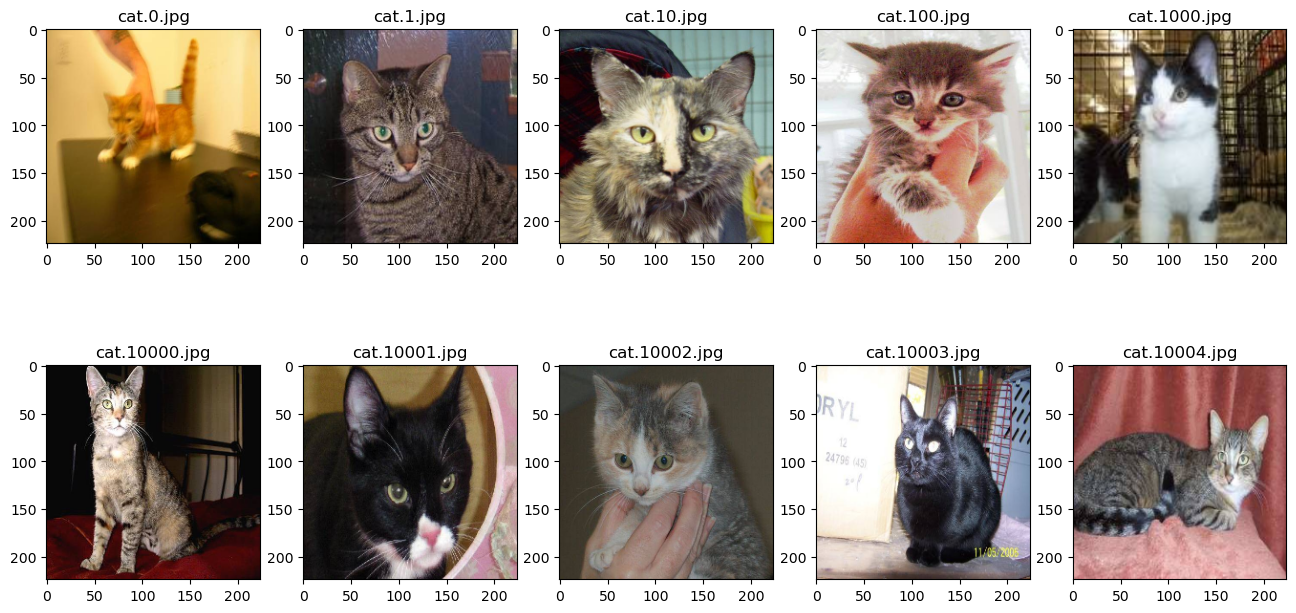

In [3]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('\\')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten()) #Преобразует многомерный массив выходов базовой модели в одномерный массив
model.add(Dense(256, activation='relu')) #Полносвязный слой с 256 нейронами и активацией ReLU
model.add(Dropout(0.5)) #Слой дропаут, который случайным образом отключает 50% нейронов во время обучения для предотвращения переобучения
model.add(Dense(1, activation='sigmoid')) #Выходной слой с одним нейроном и сигмоидальной активацией для бинарной классификации

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [8]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
history = model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 7.4551 - accuracy: 0.8188 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 2.4206 - accuracy: 0.9625 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 2.4633 - accuracy: 0.9719 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 4.2614 - accuracy: 0.9406 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 18s 2s/step - loss: 3.4316 - accuracy: 0.9406 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 1.7947 - accuracy: 0.9656 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 17s 2s/step - loss: 1.7404 - accuracy: 0.9781 - val_loss: 0.0000e+00 - val_ac

In [9]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 861s 69ms/step


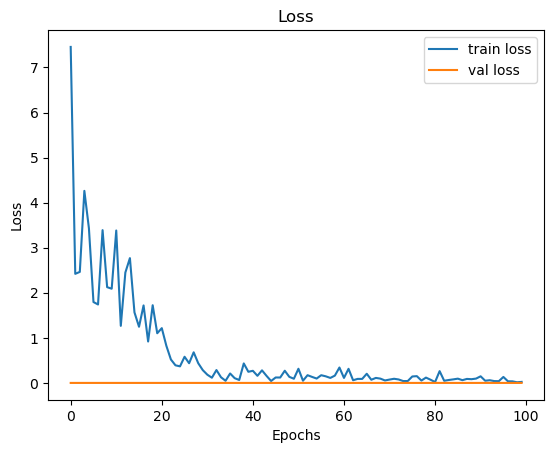

In [10]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

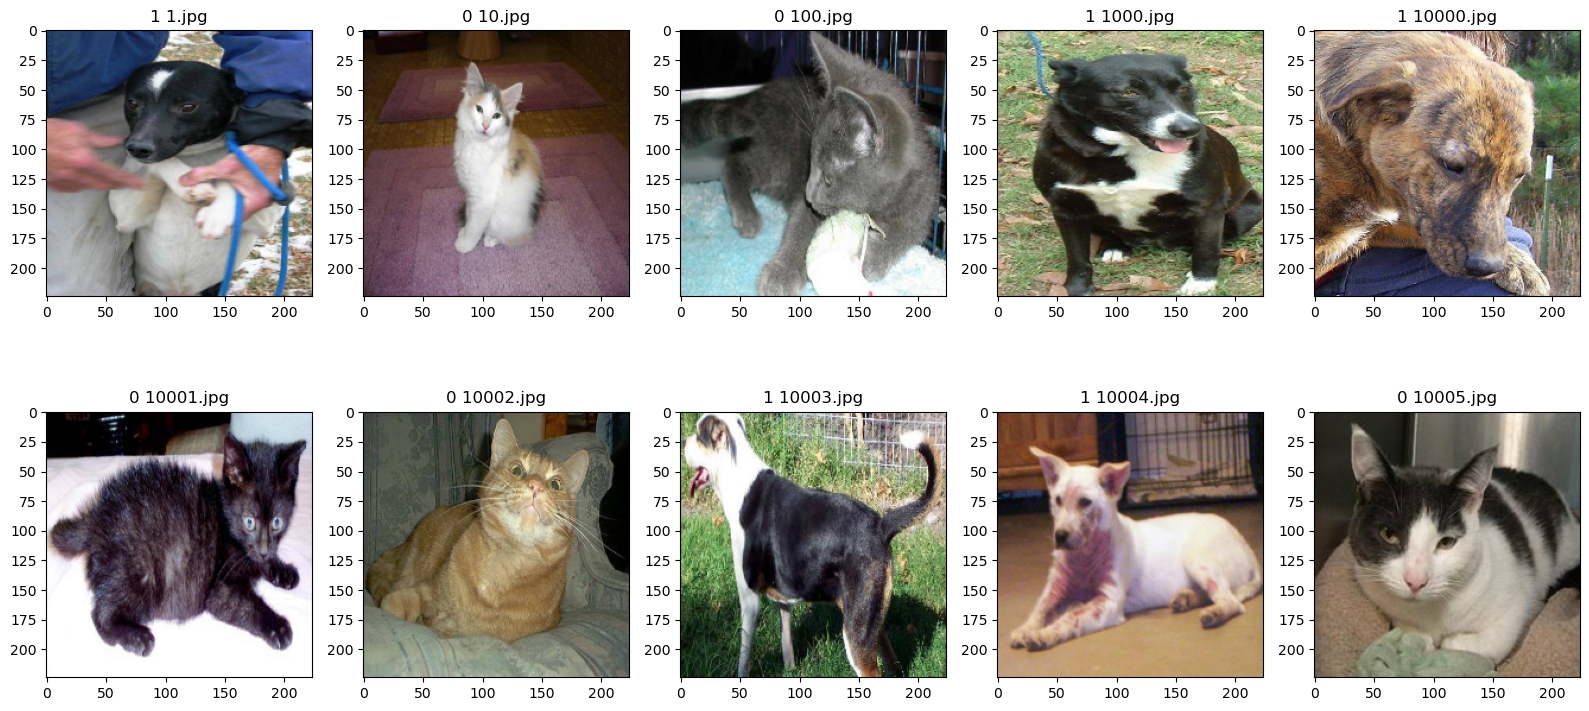

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    score_value = score.item() if isinstance(score, np.ndarray) else score
    subplot.set_title('%.0f %s' % (score_value, os.path.basename(path)))
    img = cv2.imread(path)[..., ::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)
plt.tight_layout()
plt.show()

In [15]:
submission_df = pd.DataFrame({
    'id': np.arange(1, len(test_pred.reshape(-1)) + 1),
    'label': test_pred.reshape(-1)
})
submission_df.to_csv('submission.csv', index=False)

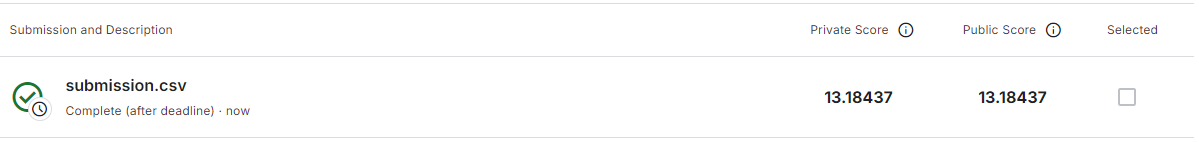